In [1]:
import os
import librosa
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.config import list_physical_devices

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
class RAVDESS_Dataset:
    def __init__(self):
        # Paths for data.
        self.path = "ravdess/"
    
    def create_file_path_list(self):

        ravdess_directory_list = os.listdir(self.path)

        file_emotion = []
        file_path = []
        for dir in ravdess_directory_list:
            # as their are 20 different actors in our previous directory we need to extract files for each actor.
            actor = os.listdir(self.path + dir)
            for file in actor:
                part = file.split('.')[0]
                part = part.split('-')
                # third part in each file represents the emotion associated to that file.
                file_emotion.append(int(part[2]))
                file_path.append(self.path + dir + '/' + file)
                
        # dataframe for emotion of files
        emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

        # dataframe for path of files.
        path_df = pd.DataFrame(file_path, columns=['Path'])
        Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

        # changing integers to actual emotions.
        Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
        Ravdess_df.head()

        # creating Dataframe using all the 4 dataframes we created so far.
        #data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
        data_path = pd.concat([Ravdess_df], axis = 0)
        data_path.to_csv("data_path.csv",index=False)
        data_path.head()
        
    def extract_features(self, data):
        # taking a random example and checking for its sample_rate.
        _ , sample_rate = librosa.load("ravdess/Actor_01/03-01-01-01-01-01-01.wav")

        # ZCR (Zero Crossing Rate)
        result = np.array([])
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
        result=np.hstack((result, zcr)) # stacking horizontally

        # MFCC (Mel-frequnecy Cepstral Coefficients)
        mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)
        result = np.hstack((result, mfcc)) # stacking horizontally

        # MelSpectogram
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel)) # stacking horizontally

        # Spectral constrat
        spect_contr = np.mean(librosa.feature.spectral_contrast(data, sr=sample_rate).T, axis=0)
        result = np.hstack((result, spect_contr))

        return result
    
    def noise(self, data):
        noise_amp = 0.035*np.random.uniform()*np.amax(data)
        data = data + noise_amp*np.random.normal(size=data.shape[0])
        return data

    def stretch(self, data, rate=0.8):
        return librosa.effects.time_stretch(data, rate)

    def shift(self, data):
        shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
        return np.roll(data, shift_range)
    
    def pitch(self, data, sampling_rate, pitch_factor=0.7):
        return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
    
    def get_features(self, path):
        # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
        data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
        
        # without augmentation
        res1 = self.extract_features(data=data)
        result = np.array(res1)
        
        # data with noise
        noise_data = self.noise(data)
        res2 = self.extract_features(noise_data)
        result = np.vstack((result, res2)) # stacking vertically
        
        # data with stretching and pitching
        new_data = self.stretch(data)
        data_stretch_pitch = self.pitch(new_data, sample_rate)
        res3 = self.extract_features(data_stretch_pitch)
        result = np.vstack((result, res3)) # stacking vertically
        
        return result
    
    def create_dataset(self):

        if os.path.exists("ravdess_dataset_augmented.csv")==False:
            print("Creating dataset...\n")

            if os.path.exists("data_path.csv")==False:
                self.create_file_path_list()
        
            data_path = pd.read_csv('data_path.csv')

            X, Y = [], []
            i = 0

            for path, emotion in zip(data_path.Path, data_path.Emotions):
                pth = path
                feature = self.get_features(pth)
                if i%100 == 0:
                    print(str(i) + " processed elements.")

                for element in feature:
                    X.append(element)
                    # appending emotion 3 times as we have made 2 augmentation techniques on each audio file.
                    Y.append(emotion)
                i+=1

            dataset = pd.DataFrame(X)
            dataset['labels'] = Y
            dataset.to_csv('ravdess_dataset_augmented.csv', index=False)
            dataset.head()

            return X, Y

        
        else: #if the dataset has already been created we just read the csv file and return it
            print("Getting dataset...\n")
            
            dataset = pd.read_csv('ravdess_dataset_augmented.csv')
            X = dataset.iloc[: ,:-1].values
            Y = dataset['labels'].values

            return X, Y

In [3]:
def get_model(shape, loss='categorical_crossentropy', optimizer=RMSprop(lr=0.00001, decay=1e-6), metrics=['accuracy']):
    model = Sequential()
    model.add(Conv1D(256, 8, padding='same',input_shape=(shape,1)))  # X_train.shape[1] = No. of Columns
    model.add(Activation('relu'))

    model.add(Conv1D(256, 8, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=(8)))

    model.add(Conv1D(128, 8, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 8, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 8, padding='same'))
    model.add(Activation('relu'))

    model.add(Conv1D(128, 8, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=(8)))

    model.add(Conv1D(64, 8, padding='same'))
    model.add(Activation('relu'))

    model.add(Conv1D(64, 8, padding='same'))
    model.add(Activation('relu'))
    model.add(Flatten())

    model.add(Dense(8)) # Target class number, in this case the 8 emotions
    model.add(Activation('softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

C:\Users\ASWIN\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [6]:
RAVDESS_Dataset_class = RAVDESS_Dataset()
X, Y = RAVDESS_Dataset_class.create_dataset()

# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

Getting dataset...



In [7]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, train_size=0.70, random_state=0, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, train_size=0.5, random_state=0, shuffle=True)
print("X train:" ,x_train.shape)
print("Y train:" ,y_train.shape)
print("X test:" ,x_test.shape)
print("Y test:" ,y_test.shape)
print("X val:" ,x_val.shape)
print("X val:" ,y_val.shape)

X train: (3024, 149)
Y train: (3024, 8)
X test: (648, 149)
Y test: (648, 8)
X val: (648, 149)
X val: (648, 8)


In [6]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3024, 149), (3024, 8), (648, 149), (648, 8))

In [7]:
# making our data compatible to model.  
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3024, 149, 1), (3024, 8), (648, 149, 1), (648, 8))

In [16]:
model = get_model(X.shape[1])

epochs = 400 # 100 -> 0.61 ; 
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.8, verbose=1, patience=5, min_lr=0.000001) # ReduceLROnPlateau
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience=3) # Early Stopping
history = model.fit(x_train, y_train, batch_size=64, epochs=epochs, validation_data=(x_val, y_val), callbacks=[callback, rlrp])

Epoch 1/400
48/48 [==============================] - 3s 39ms/step - loss: 2.0103 - accuracy: 0.1809 - val_loss: 2.0774 - val_accuracy: 0.1698 - lr: 1.0000e-05
Epoch 2/400
48/48 [==============================] - 2s 34ms/step - loss: 1.9741 - accuracy: 0.2077 - val_loss: 2.0757 - val_accuracy: 0.1620 - lr: 1.0000e-05
Epoch 3/400
48/48 [==============================] - 2s 34ms/step - loss: 1.9483 - accuracy: 0.2259 - val_loss: 2.0733 - val_accuracy: 0.1636 - lr: 1.0000e-05
Epoch 4/400
48/48 [==============================] - 2s 34ms/step - loss: 1.9293 - accuracy: 0.2318 - val_loss: 2.0701 - val_accuracy: 0.1728 - lr: 1.0000e-05
Epoch 5/400
48/48 [==============================] - 2s 35ms/step - loss: 1.9007 - accuracy: 0.2477 - val_loss: 2.0648 - val_accuracy: 0.1682 - lr: 1.0000e-05
Epoch 6/400
48/48 [==============================] - 2s 36ms/step - loss: 1.8824 - accuracy: 0.2566 - val_loss: 2.0570 - val_accuracy: 0.1728 - lr: 1.0000e-05
Epoch 7/400
48/48 [===========================

48/48 [==============================] - 2s 35ms/step - loss: 0.7603 - accuracy: 0.7417 - val_loss: 1.1032 - val_accuracy: 0.5941 - lr: 1.0000e-05
Epoch 104/400
48/48 [==============================] - 2s 37ms/step - loss: 0.7574 - accuracy: 0.7242 - val_loss: 1.0862 - val_accuracy: 0.6188 - lr: 1.0000e-05
Epoch 105/400
48/48 [==============================] - 2s 36ms/step - loss: 0.7525 - accuracy: 0.7335 - val_loss: 1.0801 - val_accuracy: 0.6265 - lr: 1.0000e-05
Epoch 106/400
48/48 [==============================] - 2s 36ms/step - loss: 0.7400 - accuracy: 0.7460 - val_loss: 1.0906 - val_accuracy: 0.6003 - lr: 1.0000e-05
Epoch 107/400
48/48 [==============================] - 2s 36ms/step - loss: 0.7438 - accuracy: 0.7470 - val_loss: 1.0644 - val_accuracy: 0.6157 - lr: 1.0000e-05
Epoch 108/400
48/48 [==============================] - 2s 36ms/step - loss: 0.7337 - accuracy: 0.7497 - val_loss: 1.0667 - val_accuracy: 0.6157 - lr: 1.0000e-05
Epoch 109/400
48/48 [===========================

Epoch 154/400
48/48 [==============================] - 2s 37ms/step - loss: 0.4932 - accuracy: 0.8363 - val_loss: 0.9501 - val_accuracy: 0.6420 - lr: 1.0000e-05
Epoch 155/400
48/48 [==============================] - 2s 36ms/step - loss: 0.4950 - accuracy: 0.8337 - val_loss: 1.0357 - val_accuracy: 0.6281 - lr: 1.0000e-05
Epoch 156/400
48/48 [==============================] - 2s 36ms/step - loss: 0.4928 - accuracy: 0.8393 - val_loss: 0.9007 - val_accuracy: 0.6698 - lr: 1.0000e-05
Epoch 157/400
48/48 [==============================] - 2s 36ms/step - loss: 0.5047 - accuracy: 0.8261 - val_loss: 0.9521 - val_accuracy: 0.6497 - lr: 1.0000e-05
Epoch 158/400
48/48 [==============================] - 2s 36ms/step - loss: 0.4895 - accuracy: 0.8284 - val_loss: 1.0510 - val_accuracy: 0.5926 - lr: 1.0000e-05
Epoch 159/400
48/48 [==============================] - 2s 36ms/step - loss: 0.4820 - accuracy: 0.8446 - val_loss: 0.9394 - val_accuracy: 0.6512 - lr: 1.0000e-05
Epoch 160/400
48/48 [=============

## Model V1:
#### Hyperparameters:
Conv1D -> Data Augmentation = Noise, Streching, Pitching                                                           
epochs = 400 # 100 -> 0.61 ;                                                                              
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.8, verbose=1, patience=5, min_lr=0.000001) # ReduceLROnPlateau                 
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience=3) # Early Stopping                       
history = model.fit(x_train, y_train, batch_size=64, epochs=epochs, validation_data=(x_val, y_val), callbacks=[callback, rlrp])                                                                             
Accuracy -> 74.38                                                                                   

In [17]:
# Save Model 
model.save('modelV1.h5')

In [2]:
model = load_model('model.h5')

In [15]:
test = x_test[0].reshape(1, 149, 1)
test.shape

(1, 149, 1)

In [16]:
preds = model.predict(test)

1/1 [==============================] - 5s 5s/step


In [17]:
preds

array([[0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [18]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

21/21 [==============================] - 0s 8ms/step - loss: 0.7880 - accuracy: 0.7438
Accuracy of our model on test data :  74.38271641731262 %


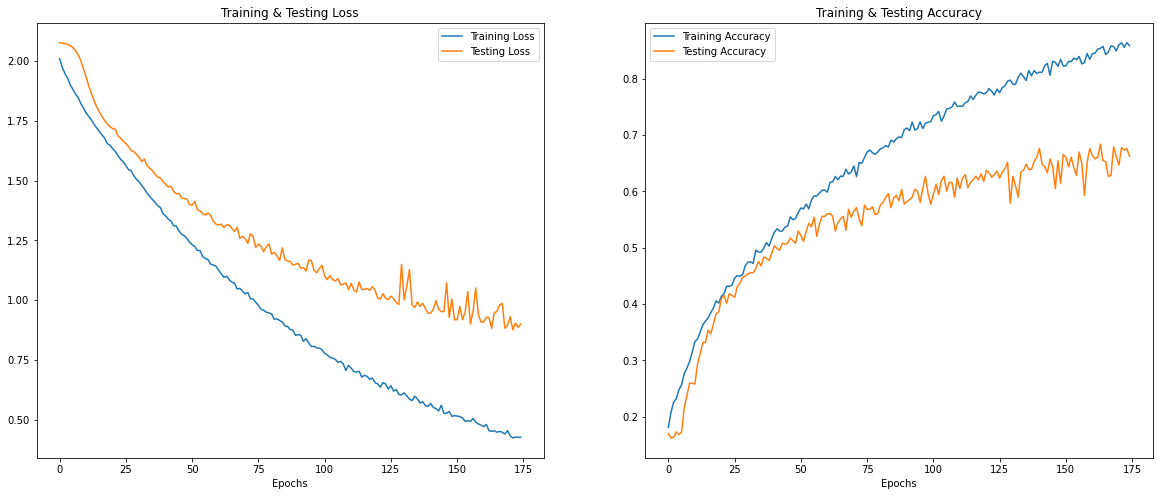

In [23]:
ep = [i for i in range(epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,8)
ax[0].plot(ep[:175] , train_loss , label = 'Training Loss')
ax[0].plot(ep[:175] , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(ep[:175] , train_acc , label = 'Training Accuracy')
ax[1].plot(ep[:175] , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.savefig('train_loss_accuracy.png')

21/21 [==============================] - 0s 6ms/step


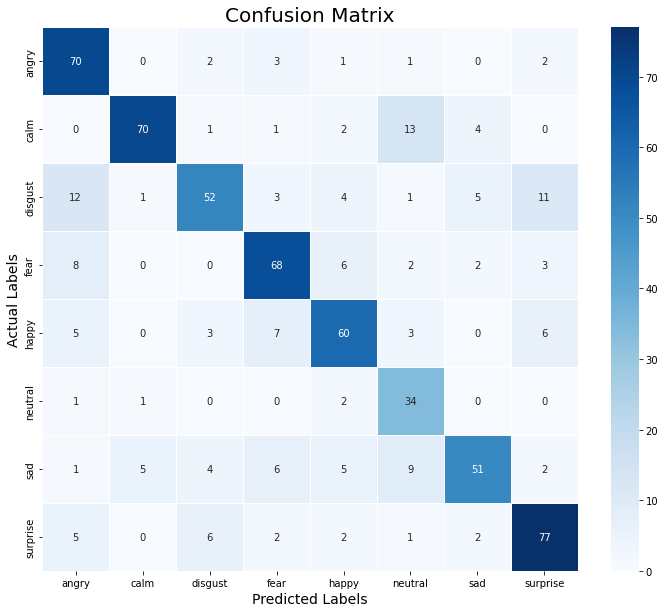

In [24]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('confusion_matrix.png')